In [1]:
import os
import numpy as np
import torch
import torch.optim as optim
import torch.distributions as D
from src.Tmy_svgd import tmySVGD
from src.svgd import SVGD
from src.gsvgd import FullGSVGDBatch
from src.kernel import RBF, BatchRBF
from src.utils import plot_particles

from src.manifold import Grassmann
from src.s_svgd import SlicedSVGD
from src.mysvgd import mySVGD

import pickle
import argparse
import time
import torch
import torch.optim as optim
import torch.autograd as autograd
import autograd.numpy as np
from tqdm import tqdm, trange

import torch.distributions as D
import matplotlib.pyplot as plt

/home/zhoujk/anaconda3/envs/AG/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser(description='Running xshaped experiment.')
d = 8
parser.add_argument('--dim', type=int, default=d, help='dimension')
s = 50
parser.add_argument('--effdim', type=int, default=-1, help='dimension')
parser.add_argument('--lr', type=float, default=0.01, help='learning rate')
parser.add_argument('--delta', type=float,default=0.01,help='stepsize for projections')
parser.add_argument('--T', type=float, default=1e-4, help='noise multiplier for projections')
parser.add_argument('--lr_g', type=float, default=0.1, help='learning rate for g')
parser.add_argument('--nparticles', type=int,default=s, help='no. of particles')
parser.add_argument('--epochs', type=int, default=10000, help='no. of epochs')
parser.add_argument('--metric', type=str, default="energy", help='distance metric')
parser.add_argument('--noise', type=str, default="True", help='whether to add noise')
parser.add_argument('--kernel', type=str, default="rbf", help='kernel')
parser.add_argument('--gpu', type=int, default=3, help='gpu')
parser.add_argument('--seed', type=int, default=235, help='random seed')
parser.add_argument('--suffix', type=str, default="", help='suffix for res folder')
parser.add_argument('--m', type=int, help='no. of projections')
parser.add_argument('--save_every', type=int, default=200, help='step intervals to save particles')
parser.add_argument('--method', type=str, default="all", help='which method to use')

_StoreAction(option_strings=['--method'], dest='method', nargs=None, const=None, default='all', type=<class 'str'>, choices=None, required=False, help='which method to use', metavar=None)

In [3]:
args = parser.parse_args([])
dim = args.dim
lr = args.lr
lr_gsvgd = args.lr
delta = args.delta
T = args.T
nparticles = args.nparticles
epochs = args.epochs
seed = args.seed
eff_dims = [args.effdim] if args.effdim > 0 else [1, 2, 5]
save_every = args.save_every # save metric values
print(f"Running for dim: {dim}, lr: {lr}, nparticles: {nparticles}")

Running for dim: 8, lr: 0.01, nparticles: 50


In [4]:
device = torch.device(f'cuda:{args.gpu}' if args.gpu != -1 else 'cpu')

metric = args.metric

results_folder = f"./res/gaussian{args.suffix}/{args.kernel}_epoch{epochs}_lr{lr}_delta{delta}_n{nparticles}_dim{dim}"
results_folder = f"{results_folder}/seed{seed}"

In [5]:
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

if args.kernel == "rbf":
    Kernel = RBF
    BatchKernel = BatchRBF

In [6]:
print(f"Device: {device}")
torch.manual_seed(seed)

## target density
means = torch.zeros(dim, device=device)

torch.manual_seed(0)
'''A
A = torch.randn(dim,dim).to('cuda') * 0.9
A = torch.matmul(A, A.T)

m = torch.max(A) 
B = torch.eye(dim).to('cuda') * m + 0.1
diag = torch.diag(A)
cov = A + B'''

cov = torch.eye(dim, device=device)

distribution = D.MultivariateNormal(means.to(device), cov)

# sample from target (for computing metric)
x_target = distribution.sample((nparticles, ))
# sample from variational density
torch.manual_seed(235)
x_init = 2 + np.sqrt(2) * torch.randn(nparticles, *distribution.event_shape, device=device)



    
    

Device: cuda:3


Running SVGD


100%|██████████| 10000/10000 [00:20<00:00, 490.88it/s]
/home/zhoujk/anaconda3/envs/AG/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


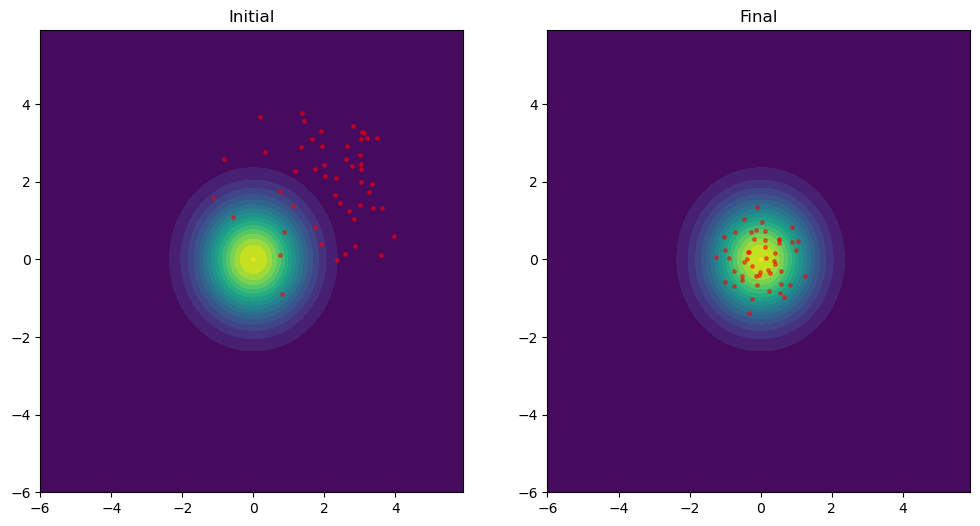

In [7]:
## SVGD
if args.method in ["SVGD", "all"]:
    print("Running SVGD")
    # sample from variational density
    x = x_init.clone().to(device)
    kernel = Kernel(method="med_heuristic")
    svgd = SVGD(distribution, kernel, optim.Adam([x], lr=lr), device=device)
    start = time.time()
    svgd.fit(x, epochs, verbose=True, save_every=save_every)
    elapsed_time_svgd = time.time() - start

    # plot particles
    fig_svgd = plot_particles(
        x_init.detach(), 
        x.detach(), 
        distribution, 
        d=6.0, 
        step=0.1, 
        concat=means[2:],
        savedir=results_folder + f"/svgd.png"
    )

tensor(1.8058, device='cuda:3')
tensor([[ 3.5806e-01, -1.5421e-03,  2.6348e-05, -5.0836e-04, -1.1518e-03,
          4.4135e-04,  7.1763e-04,  7.2974e-04],
        [-1.5421e-03,  3.6350e-01, -1.1897e-03,  7.8321e-04, -1.1607e-03,
          9.5983e-04,  1.2220e-03,  8.1301e-04],
        [ 2.6348e-05, -1.1897e-03,  3.6130e-01,  2.3238e-04,  1.4428e-04,
         -1.8916e-03, -1.1251e-03, -1.2851e-03],
        [-5.0836e-04,  7.8321e-04,  2.3238e-04,  3.6068e-01, -1.5423e-03,
          5.7305e-04,  4.2309e-04, -8.2042e-04],
        [-1.1518e-03, -1.1607e-03,  1.4428e-04, -1.5423e-03,  3.6231e-01,
         -5.6378e-04, -1.1145e-03, -6.5697e-04],
        [ 4.4135e-04,  9.5983e-04, -1.8916e-03,  5.7305e-04, -5.6378e-04,
          3.6174e-01,  9.7845e-04,  1.4217e-03],
        [ 7.1763e-04,  1.2220e-03, -1.1251e-03,  4.2309e-04, -1.1145e-03,
          9.7845e-04,  3.6124e-01, -2.2878e-03],
        [ 7.2974e-04,  8.1301e-04, -1.2851e-03, -8.2042e-04, -6.5697e-04,
          1.4217e-03, -2.2878e-03

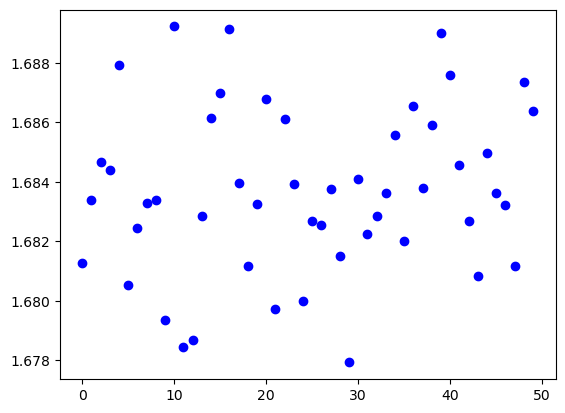

In [8]:
theta  = x
index_svgd = []
samn_svgd = []
for i in range(theta.shape[0]):
    samn_svgd.append(torch.linalg.norm(theta[i,:].cpu()).item())
    index_svgd.append(i)

import matplotlib.pyplot as plt
plt.scatter(index_svgd, samn_svgd, c='blue')
cov_svgd = torch.cov(theta.T)
print(torch.linalg.norm(cov - cov_svgd))
print(cov_svgd)
print(cov - cov_svgd)

Running mySVGD


  1%|          | 1/100 [00:02<03:22,  2.04s/it]

tensor(1.9229, device='cuda:3')
tensor(1.6108, device='cuda:3')


  6%|▌         | 6/100 [00:12<03:12,  2.05s/it]

tensor(0.8704, device='cuda:3')
tensor(0.0280, device='cuda:3')


 11%|█         | 11/100 [00:22<02:59,  2.02s/it]

tensor(0.8997, device='cuda:3')
tensor(0.0164, device='cuda:3')


 16%|█▌        | 16/100 [00:32<02:56,  2.10s/it]

tensor(0.8938, device='cuda:3')
tensor(0.0199, device='cuda:3')


 21%|██        | 21/100 [00:42<02:40,  2.03s/it]

tensor(0.9572, device='cuda:3')
tensor(0.0309, device='cuda:3')


 26%|██▌       | 26/100 [00:53<02:43,  2.20s/it]

tensor(0.9685, device='cuda:3')
tensor(0.0182, device='cuda:3')


 31%|███       | 31/100 [01:04<02:24,  2.10s/it]

tensor(1.0063, device='cuda:3')
tensor(0.0181, device='cuda:3')


 36%|███▌      | 36/100 [01:14<02:09,  2.02s/it]

tensor(1.0921, device='cuda:3')
tensor(0.0146, device='cuda:3')


 41%|████      | 41/100 [01:23<01:55,  1.95s/it]

tensor(1.2290, device='cuda:3')
tensor(0.0192, device='cuda:3')


 46%|████▌     | 46/100 [01:33<01:48,  2.01s/it]

tensor(1.1091, device='cuda:3')
tensor(0.0221, device='cuda:3')


 51%|█████     | 51/100 [01:43<01:39,  2.03s/it]

tensor(0.9624, device='cuda:3')
tensor(0.0115, device='cuda:3')


 56%|█████▌    | 56/100 [01:54<01:32,  2.10s/it]

tensor(0.8354, device='cuda:3')
tensor(0.0182, device='cuda:3')


 61%|██████    | 61/100 [02:04<01:20,  2.07s/it]

tensor(0.7601, device='cuda:3')
tensor(0.0229, device='cuda:3')


 66%|██████▌   | 66/100 [02:15<01:09,  2.05s/it]

tensor(0.8328, device='cuda:3')
tensor(0.0264, device='cuda:3')


 71%|███████   | 71/100 [02:25<00:59,  2.04s/it]

tensor(0.8458, device='cuda:3')
tensor(0.0271, device='cuda:3')


 76%|███████▌  | 76/100 [02:36<00:52,  2.18s/it]

tensor(0.8757, device='cuda:3')
tensor(0.0199, device='cuda:3')


 81%|████████  | 81/100 [02:46<00:40,  2.12s/it]

tensor(0.8905, device='cuda:3')
tensor(0.0256, device='cuda:3')


 86%|████████▌ | 86/100 [02:56<00:28,  2.07s/it]

tensor(0.9180, device='cuda:3')
tensor(0.0216, device='cuda:3')


 91%|█████████ | 91/100 [03:06<00:18,  2.06s/it]

tensor(0.9780, device='cuda:3')
tensor(0.0176, device='cuda:3')


 96%|█████████▌| 96/100 [03:17<00:08,  2.17s/it]

tensor(1.0819, device='cuda:3')
tensor(0.0199, device='cuda:3')


100%|██████████| 100/100 [03:26<00:00,  2.06s/it]


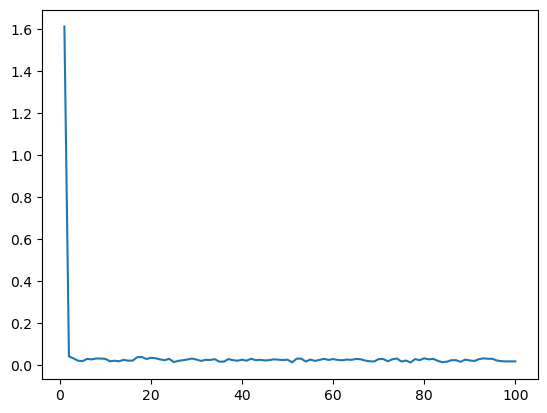

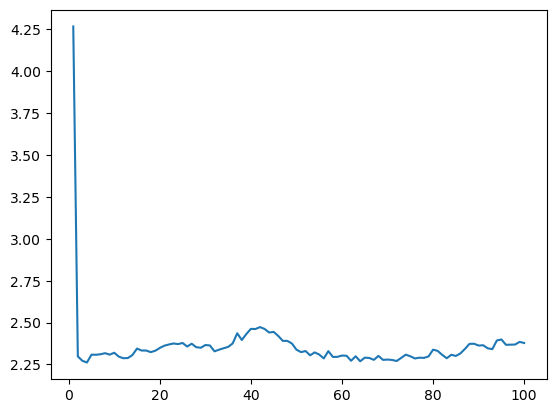

In [9]:
print("Running mySVGD")

def score(X):
        X_cp = X.clone().detach().requires_grad_()
        log_prob = distribution.log_prob(X_cp)
        score_func = autograd.grad(log_prob.sum(), X_cp)[0]
        return score_func


# sample from variational density
res = []
rres = []
steps = []
lr = 0.01
x0 = x_init
vector1  = torch.randn(nparticles, dim).to(device)

for i in trange(100):
    
    theta, vector = mySVGD().update(x0, score,  k = 2, n_iter = 50,  debug = False, lr= lr, vector=vector1, device=device)
    #mean = np.mean(theta, axis=0)  + np.random.random(1)
    #var_theta = np.cov(theta.T) + np.random.random(1)
    #x0 = np.random.multivariate_normal(mean, var_theta,num)
    x0 = theta
    vector1 = vector
    
    # res.append(np.linalg.norm(theta)/D)
    
    mean_svgd = torch.mean(theta, axis=0)

    var_svgd = torch.cov(theta.T) 
    res.append(torch.linalg.norm(mean_svgd).item())
    rres.append(torch.linalg.norm(var_svgd).item()) 
    if i % 5 == 0:
        
        print(torch.linalg.norm(cov- var_svgd) )
        print(torch.linalg.norm(mean_svgd - means))
    
leng = len(res)
x = np.arange(1,leng+1)
plt.figure(1)
plt.plot(x,res)
plt.figure(2)
plt.plot(x,rres)

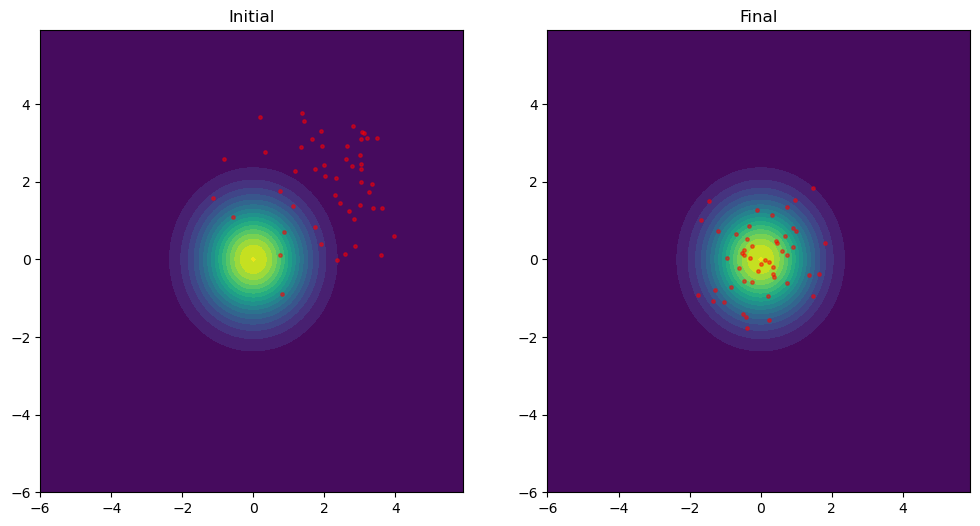

In [10]:
fig_svgd = plot_particles(
        x_init.detach(), 
        theta.detach(), 
        distribution, 
        d=6.0, 
        step=0.1, 
        concat=means[2:]
    )

tensor(1.0262, device='cuda:3')
tensor([[ 7.6792e-01,  1.4980e-01,  9.8637e-03, -3.0136e-03, -1.6133e-01,
         -1.5763e-01, -4.2323e-02, -7.0762e-02],
        [ 1.4980e-01,  7.3571e-01,  7.6409e-03, -3.1053e-03, -1.1510e-01,
          7.2225e-02, -7.8279e-02, -2.9012e-01],
        [ 9.8637e-03,  7.6409e-03,  8.6579e-01, -2.7488e-03, -8.2169e-03,
         -4.8120e-03, -1.3280e-03,  2.6404e-03],
        [-3.0136e-03, -3.1053e-03, -2.7488e-03,  8.9254e-01, -2.5518e-04,
         -9.0692e-03,  8.5279e-04,  7.5268e-03],
        [-1.6133e-01, -1.1510e-01, -8.2169e-03, -2.5518e-04,  7.7176e-01,
          2.5777e-01, -1.5722e-01,  1.3187e-01],
        [-1.5763e-01,  7.2225e-02, -4.8120e-03, -9.0692e-03,  2.5777e-01,
          7.7415e-01,  1.1114e-01, -4.0471e-02],
        [-4.2323e-02, -7.8279e-02, -1.3280e-03,  8.5279e-04, -1.5722e-01,
          1.1114e-01,  7.4839e-01, -1.4963e-01],
        [-7.0762e-02, -2.9012e-01,  2.6404e-03,  7.5268e-03,  1.3187e-01,
         -4.0471e-02, -1.4963e-01

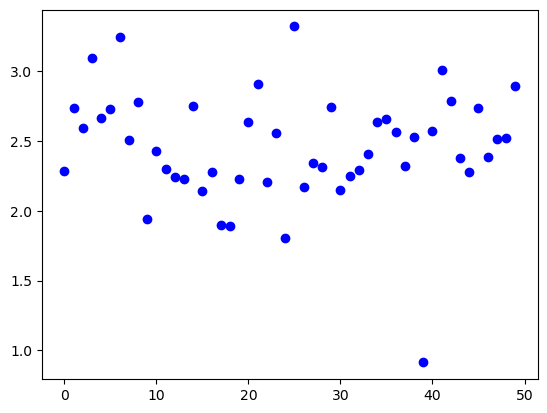

In [11]:
index_svgd = []
samn_svgd = []
for i in range(theta.shape[0]):
    samn_svgd.append(torch.linalg.norm(theta[i,:].cpu()).item())
    index_svgd.append(i)

import matplotlib.pyplot as plt
plt.scatter(index_svgd, samn_svgd, c='blue')
cov_svgd = torch.cov(theta.T)
print(torch.linalg.norm(cov - cov_svgd))
print(cov_svgd)
print(cov - cov_svgd)

Running tmySVGD


  0%|          | 1/200 [00:02<08:03,  2.43s/it]

tensor(2.3055, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)
tensor(3.8022, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)


 10%|█         | 21/200 [00:49<07:09,  2.40s/it]

tensor(1.4324, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0161, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)


 20%|██        | 41/200 [01:37<06:15,  2.36s/it]

tensor(1.4126, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0075, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)


 30%|███       | 61/200 [02:26<05:45,  2.48s/it]

tensor(1.4151, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0064, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)


 40%|████      | 81/200 [03:15<04:53,  2.46s/it]

tensor(1.4141, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0066, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)


 50%|█████     | 101/200 [04:04<03:57,  2.40s/it]

tensor(1.4075, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0056, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)


 60%|██████    | 121/200 [04:51<03:05,  2.35s/it]

tensor(1.4069, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0062, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)


 70%|███████   | 141/200 [05:40<02:20,  2.38s/it]

tensor(1.4032, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0047, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)


 80%|████████  | 161/200 [06:28<01:33,  2.41s/it]

tensor(1.3991, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0060, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)


 90%|█████████ | 181/200 [07:17<00:46,  2.46s/it]

tensor(1.3988, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0052, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)


100%|██████████| 200/200 [08:03<00:00,  2.42s/it]


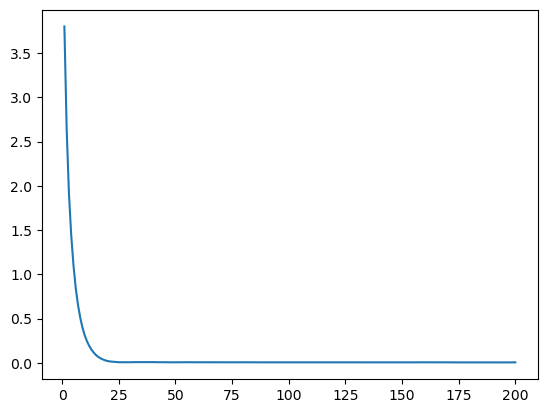

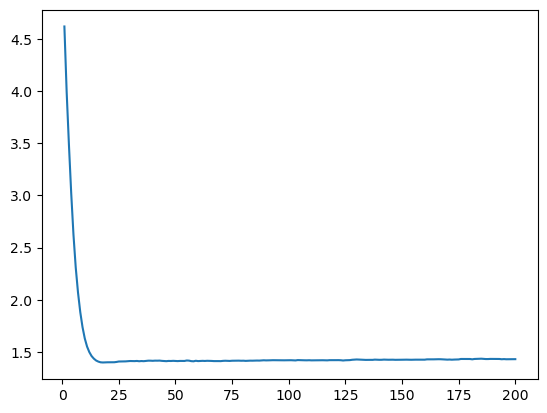

In [12]:
print("Running tmySVGD")

def score(X):
        X_cp = X.clone().detach().requires_grad_()
        log_prob = distribution.log_prob(X_cp)
        score_func = autograd.grad(log_prob.sum(), X_cp)[0]
        return score_func


# sample from variational density
res = []
rres = []
steps = []
lr = 0.1
x0 = x_init
vector1  = torch.randn(nparticles, dim).to(device)

for i in trange(200):
    
    theta, vector = tmySVGD(kernel).update(x0, score,  k = 2, n_iter = 50,  debug = False, lr= lr, vector=vector1)
    #mean = np.mean(theta, axis=0)  + np.random.random(1)
    #var_theta = np.cov(theta.T) + np.random.random(1)
    #x0 = np.random.multivariate_normal(mean, var_theta,num)
    x0 = theta
    vector1 = vector
    mean_svgd = torch.mean(theta, axis=0)

    var_svgd = torch.cov(theta.T) 
    res.append(torch.linalg.norm(mean_svgd).item())
    rres.append(torch.linalg.norm(var_svgd).item()) 

    if i % 20 == 0:
        
        print(torch.linalg.norm(cov- var_svgd) )
        print(torch.linalg.norm(mean_svgd - means))
        
    
    
leng = len(res)
x = np.arange(1,leng+1)
plt.figure(1)
plt.plot(x,res)
plt.figure(2)
plt.plot(x,rres)
    
 

tensor(1.3972, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)
tensor([[ 4.9382e-01,  4.3663e-04, -1.0263e-02, -5.0198e-04, -4.1300e-03,
         -9.1897e-04, -5.9136e-04, -2.8028e-03],
        [ 4.3663e-04,  4.9357e-01,  5.7736e-05,  1.3645e-03, -2.0962e-03,
         -6.0361e-03, -1.7548e-03,  6.5584e-03],
        [-1.0263e-02,  5.7736e-05,  4.9372e-01, -1.9940e-03,  4.4361e-03,
         -2.6386e-03,  3.9298e-03, -2.6639e-03],
        [-5.0198e-04,  1.3645e-03, -1.9940e-03,  4.9403e-01,  1.3921e-03,
          5.1388e-03, -3.6735e-03,  1.3249e-02],
        [-4.1300e-03, -2.0962e-03,  4.4361e-03,  1.3921e-03,  4.9392e-01,
         -2.0214e-03, -2.2865e-03,  3.0302e-03],
        [-9.1897e-04, -6.0361e-03, -2.6386e-03,  5.1388e-03, -2.0214e-03,
          4.9391e-01,  3.4975e-03,  5.4037e-03],
        [-5.9136e-04, -1.7548e-03,  3.9298e-03, -3.6735e-03, -2.2865e-03,
          3.4975e-03,  4.9385e-01, -8.6283e-03],
        [-2.8028e-03,  6.5584e-03, -2.6639e-03,  1.3249e-02,  3.0302e-

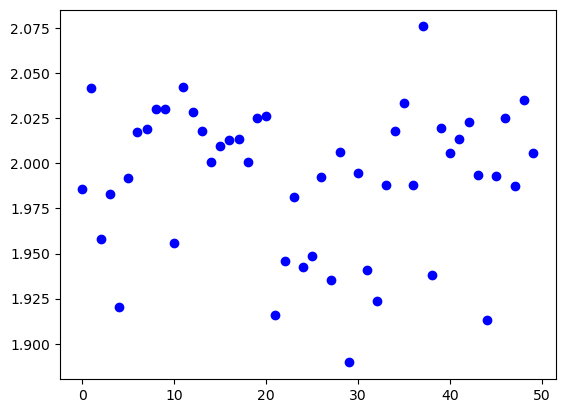

In [13]:

index_svgd = []
samn_svgd = []
for i in range(theta.shape[0]):
    samn_svgd.append(torch.linalg.norm(theta[i,:].cpu()).item())
    index_svgd.append(i)

import matplotlib.pyplot as plt
plt.scatter(index_svgd, samn_svgd, c='blue')
cov_gsvgd = torch.cov(theta.T)
print(torch.linalg.norm(cov - cov_gsvgd))
print(cov - cov_gsvgd)

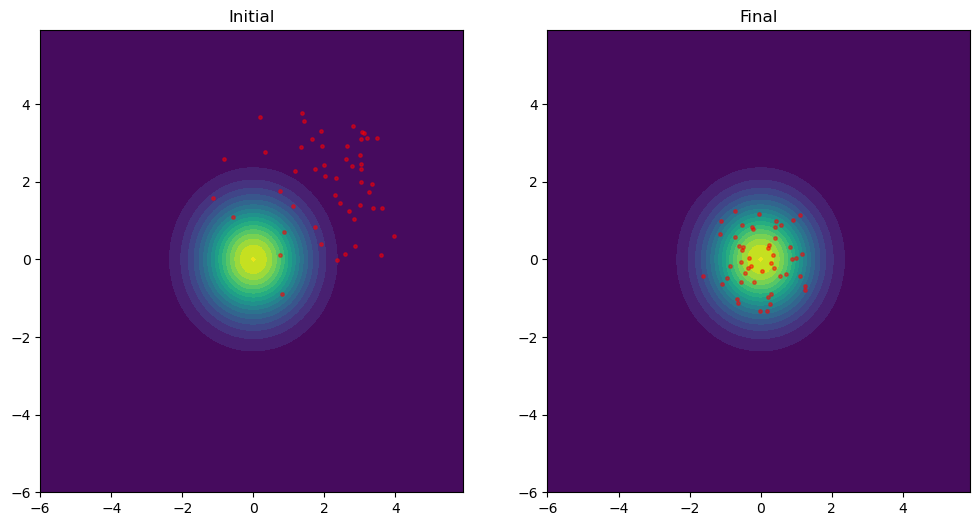

In [14]:

fig_svgd = plot_particles(
        x_init.detach(), 
        theta.detach(), 
        distribution, 
        d=6.0, 
        step=0.1, 
        concat=means[2:]
    )

Running GSVGD with eff dim = 1
number of projections: 8


 10%|▉         | 999/10000 [00:10<01:32, 97.12it/s]/home/zhoujk/SVGD/SVGD_code/GSVGD-main/src/gsvgd.py:262: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2349.)
  A, _ = torch.qr(A)
100%|██████████| 10000/10000 [01:43<00:00, 96.86it/s]


Running GSVGD with eff dim = 2
number of projections: 4


100%|██████████| 10000/10000 [01:46<00:00, 93.61it/s]


Running GSVGD with eff dim = 5
number of projections: 1


100%|██████████| 10000/10000 [01:41<00:00, 98.38it/s]


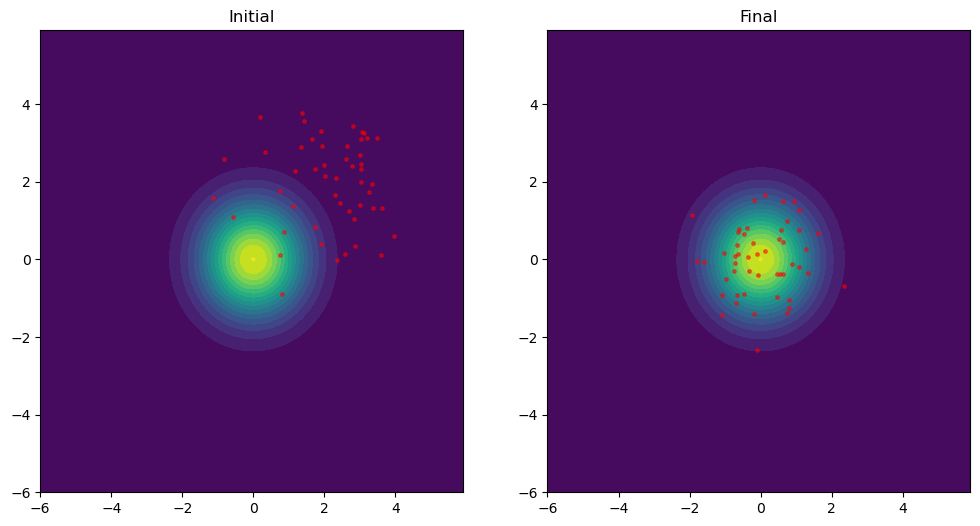

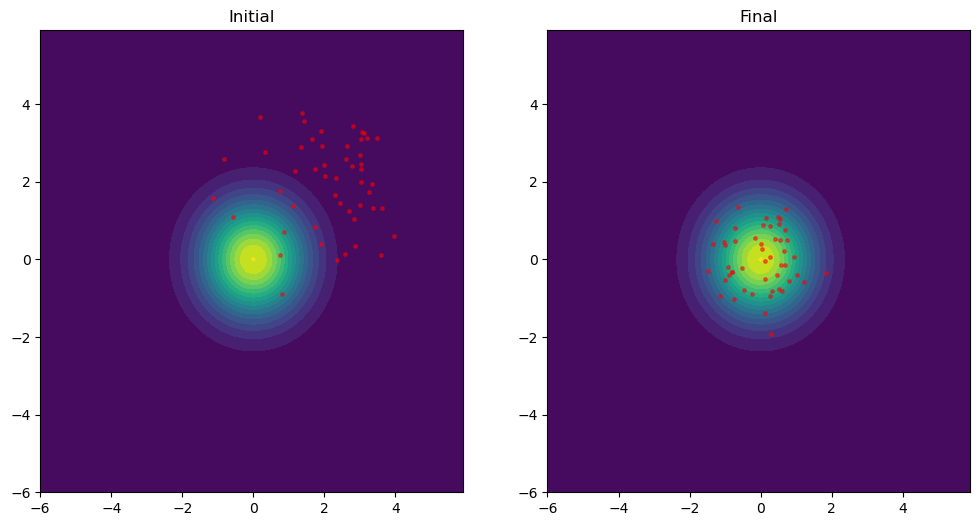

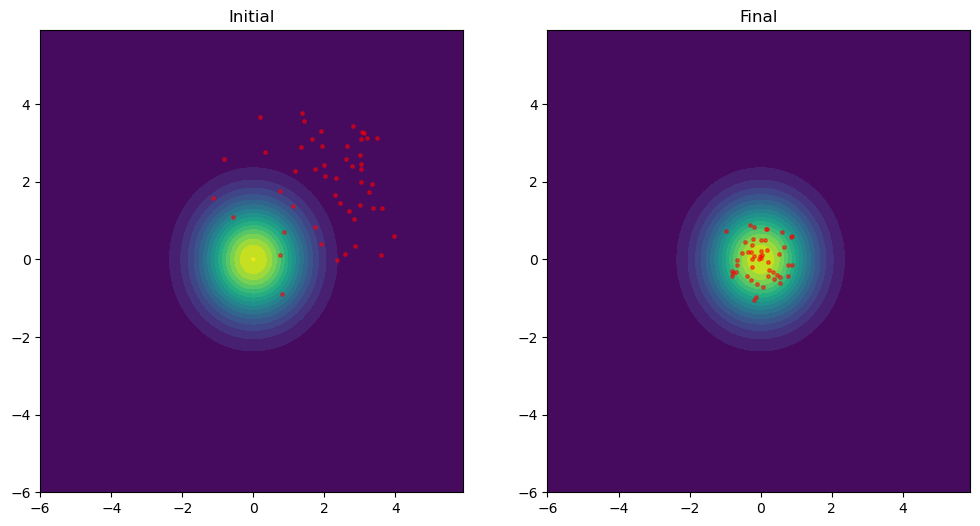

In [15]:
## GSVGD
if args.method in ["GSVGD", "all"]:
    res_gsvgd = [0] * len(eff_dims)
    def run_gsvgd(eff_dims):
        for i, eff_dim in enumerate(eff_dims):
            print(f"Running GSVGD with eff dim = {eff_dim}")

            if args.m is None:
                m = min(20, dim // eff_dim)
            elif args.m == -1:
                m = dim // eff_dim
            else:
                m = args.m
            print("number of projections:", m)

            # sample from variational density
            x_init_gsvgd = x_init.clone()
            x_gsvgd = x_init_gsvgd.clone()

            kernel_gsvgd = BatchKernel(method="med_heuristic")
            optimizer = optim.Adam([x_gsvgd], lr=lr_gsvgd)
            manifold = Grassmann(dim, eff_dim)
            U = torch.eye(dim).requires_grad_().to(device)
            U = U[:, :(m*eff_dim)]

            gsvgd = FullGSVGDBatch(
                target=distribution,
                kernel=kernel_gsvgd,
                manifold=manifold,
                optimizer=optimizer,
                delta=delta,
                T=T,
                device=device
            )
            start = time.time()
            U, metric_gsvgd = gsvgd.fit(x_gsvgd, U, m, epochs, 
                verbose=True, save_every=save_every, threshold=0.0001*m)
            elapsed_time = time.time() - start

            # plot particles
            fig_gsvgd = plot_particles(
                x_init_gsvgd.detach(), 
                x_gsvgd.detach(), 
                distribution, 
                d=6.0, 
                step=0.1, 
                concat=means[2:],
                savedir=results_folder + f"/fullgsvgd_effdim{eff_dim}_lr{lr_gsvgd}_delta{delta}_m{m}_T{T}.png"
            )

            # store results
            res_gsvgd[i] = {"init":x_init_gsvgd, "final":x_gsvgd, "metric":metric_gsvgd, 
                "fig":fig_gsvgd, "particles":gsvgd.particles, "pam":gsvgd.pam, "res": gsvgd,
                "elapsed_time": elapsed_time}
        return res_gsvgd, x_gsvgd

    res_gsvgd, x_gsvgd = run_gsvgd(eff_dims)

tensor(2.1665, device='cuda:3')
tensor([[ 7.6804e-01, -8.5831e-03,  3.3716e-03, -9.1188e-04,  4.7863e-03,
          2.3563e-04, -3.4266e-03,  1.7528e-03],
        [-8.5831e-03,  7.6684e-01,  9.0748e-04,  3.9421e-03, -7.2885e-03,
         -5.1442e-03, -1.0217e-03, -8.6447e-04],
        [ 3.3716e-03,  9.0748e-04,  7.5456e-01,  3.9687e-03,  2.1740e-03,
          5.1422e-03,  9.4004e-03,  1.0052e-02],
        [-9.1188e-04,  3.9421e-03,  3.9687e-03,  7.6377e-01, -2.6301e-03,
         -7.2710e-04,  1.3954e-02, -2.3127e-03],
        [ 4.7863e-03, -7.2885e-03,  2.1740e-03, -2.6301e-03,  7.6973e-01,
          6.9046e-03, -1.1159e-02, -2.1238e-03],
        [ 2.3563e-04, -5.1442e-03,  5.1422e-03, -7.2710e-04,  6.9046e-03,
          7.6801e-01, -1.1005e-02,  1.5784e-03],
        [-3.4266e-03, -1.0217e-03,  9.4004e-03,  1.3954e-02, -1.1159e-02,
         -1.1005e-02,  7.6779e-01, -1.3432e-02],
        [ 1.7528e-03, -8.6447e-04,  1.0052e-02, -2.3127e-03, -2.1238e-03,
          1.5784e-03, -1.3432e-02

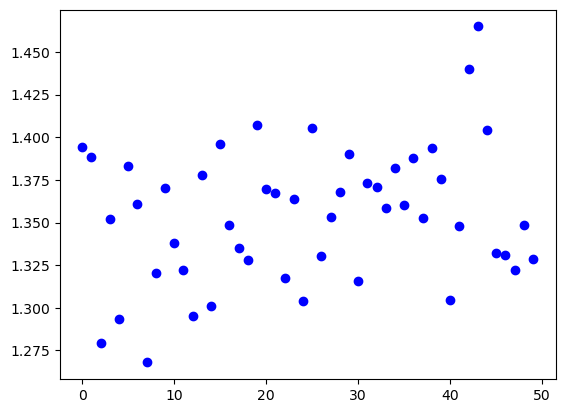

In [16]:
theta  = x_gsvgd
index_svgd = []
samn_svgd = []
for i in range(theta.shape[0]):
    samn_svgd.append(torch.linalg.norm(theta[i,:].cpu()).item())
    index_svgd.append(i)

import matplotlib.pyplot as plt
plt.scatter(index_svgd, samn_svgd, c='blue')
cov_gsvgd = torch.cov(theta.T)
print(torch.linalg.norm(cov - cov_gsvgd))
print(cov - cov_gsvgd)

Running S-SVGD


100%|██████████| 10000/10000 [00:59<00:00, 168.71it/s]


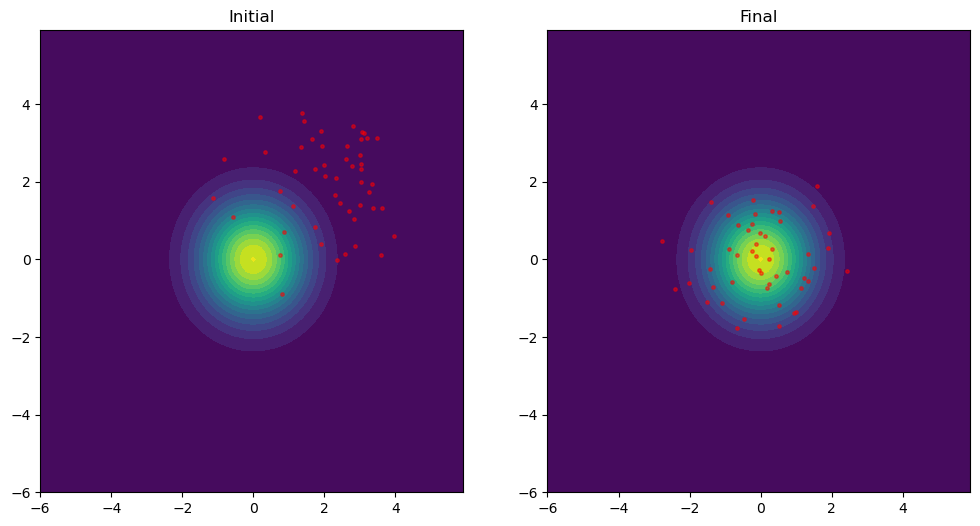

In [17]:

    
## S-SVGD
if args.method in ["S-SVGD", "all"]:
    print("Running S-SVGD")
    # sample from variational density
    x_init_s_svgd = x_init.clone()
    x_s_svgd = x_init_s_svgd.clone().requires_grad_()
    s_svgd = SlicedSVGD(distribution, device=device)

    start = time.time()
    x_s_svgd, metric_s_svgd = s_svgd.fit(
        samples=x_s_svgd, 
        n_epoch=epochs, 
        lr=args.lr_g,
        eps=lr,
        save_every=save_every
    )
    elapsed_time_s_svgd = time.time() - start

    # plot particles
    fig_s_svgd = plot_particles(
        x_init_s_svgd.detach(), 
        x_s_svgd.detach(), 
        distribution, 
        d=6.0, 
        step=0.1, 
        concat=means[2:],
        savedir=results_folder + f"/ssvgd_lr{lr}_lrg{args.lr_g}.png"
    )




tensor(2.1313, device='cuda:3', grad_fn=<LinalgVectorNormBackward0>)
tensor([[-0.3400, -0.0704,  0.0233, -0.7997, -0.3902, -0.1083,  0.0526,  0.1172],
        [-0.0704,  0.1530,  0.1819,  0.0426, -0.3121,  0.0948,  0.0041, -0.0595],
        [ 0.0233,  0.1819,  0.0283, -0.1256,  0.2988,  0.1179, -0.2485,  0.2282],
        [-0.7997,  0.0426, -0.1256, -0.7834, -0.3047, -0.2610, -0.3705,  0.2675],
        [-0.3902, -0.3121,  0.2988, -0.3047, -0.5436,  0.0646, -0.0226, -0.3912],
        [-0.1083,  0.0948,  0.1179, -0.2610,  0.0646, -0.0102,  0.0358, -0.0137],
        [ 0.0526,  0.0041, -0.2485, -0.3705, -0.0226,  0.0358, -0.0510,  0.1139],
        [ 0.1172, -0.0595,  0.2282,  0.2675, -0.3912, -0.0137,  0.1139,  0.0207]],
       device='cuda:3', grad_fn=<SubBackward0>)


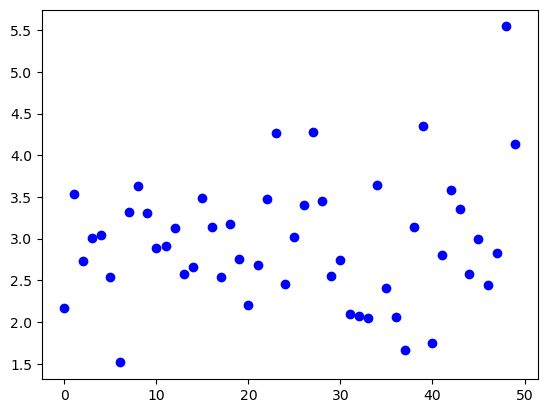

In [18]:
theta  = x_s_svgd
index_svgd = []
samn_svgd = []
for i in range(theta.shape[0]):
    samn_svgd.append(torch.linalg.norm(theta[i,:].cpu()).item())
    index_svgd.append(i)

import matplotlib.pyplot as plt
plt.scatter(index_svgd, samn_svgd, c='blue')
cov_ssvgd = torch.cov(theta.T)
print(torch.linalg.norm(cov - cov_ssvgd))
print(cov - cov_ssvgd)

In [19]:
np.sqrt(20)

4.47213595499958

: 